In [1]:
%matplotlib inline
import json
import requests
import folium
import geocoder
import urllib
import datetime
import geojson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from folium import plugins
from haversine import haversine
from scipy.spatial.distance import euclidean , cityblock
from geopy.distance import great_circle
from math import *
from bokeh.io import output_notebook,show
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, save
from bokeh.palettes import Spectral4

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
def get_lat_lng_coords(row):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Los Angeles, CA'.format(row.location))
        lat_lng_coords = g.json['raw']['feature']['geometry']

    latitude = lat_lng_coords['y']
    longitude = lat_lng_coords['x']
    
    return pd.Series([latitude, longitude])

In [3]:
# lapd_precinct_url = 'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LAPD_Police_Stations/FeatureServer/0/query?where=1%3D1&outFields=DIVISION,LOCATION,PREC&returnGeometry=false&outSR=4326&f=json'
# with urllib.request.urlopen(lapd_precinct_url) as url:
#     lapd_precinct_content = json.loads(url.read().decode())

# lapd_precinct_data = pd.DataFrame(columns=['precinct', 'division', 'location'])
    
# for row in lapd_precinct_content['features']:
#     lapd_precinct_data = lapd_precinct_data.append({
#         'precinct': row['attributes']['PREC'],
#         'division': row['attributes']['DIVISION'],
#         'location': row['attributes']['LOCATION']
#     }, ignore_index=True)
    
# lapd_precinct_data.sort_values(by='precinct', inplace=True)
# lapd_precinct_data = lapd_precinct_data.reset_index(drop=True)
# lapd_precinct_data[['latitude', 'longitude']] = lapd_precinct_data.apply(get_lat_lng_coords, axis=1)

# lapd_precinct_data.to_csv('lapd_precinct_data.csv', index=False)

In [4]:
lapd_precinct_data = pd.read_csv('lapd_precinct_data.csv')
lapd_precinct_data.head()

,precinct,division,location,latitude,longitude
0,1,CENTRAL,251 E. 6TH ST.,34.043882,-118.247710
1,2,RAMPART,1401 W. 6TH ST.,34.056330,-118.267360
2,3,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,34.010815,-118.304883
3,4,HOLLENBECK,2111 E. 1ST ST.,34.044700,-118.213150
4,5,HARBOR,2175 JOHN S. GIBSON BLVD.,33.757466,-118.288874


In [5]:
# crime_data_cols = ['DR Number', 'Date Occurred', 'Time Occurred', 'Area ID', 'Area Name', 'Crime Code Description', 'Location ']
# lapd_crime_data_raw = pd.read_csv('Crime_Data_from_2010_to_Present.csv', usecols=crime_data_cols)
# lapd_crime_data_raw.head()

In [6]:
# lapd_crime_data = lapd_crime_data_raw
# lapd_crime_data.columns = lapd_crime_data.columns.str.strip()
# lapd_crime_data.columns = lapd_crime_data.columns.str.replace('\s{2,}', ' ')
# lapd_crime_data.columns = lapd_crime_data.columns.str.replace(' ', '_')
# lapd_crime_data.columns = lapd_crime_data.columns.str.lower()
# lapd_crime_data['location'] = lapd_crime_data['location'].str.lstrip('\(').str.rstrip('\)')
# lapd_crime_data['latitude'], lapd_crime_data['longitude'] = lapd_crime_data['location'].str.split(',', 1).str
# lapd_crime_data = lapd_crime_data.drop('location', axis=1)

# lapd_crime_data.dropna(inplace=True)
# lapd_crime_data = lapd_crime_data.reset_index(drop=True)
# lapd_crime_data['latitude'] = lapd_crime_data['latitude'].astype(float)
# lapd_crime_data['longitude'] = lapd_crime_data['longitude'].astype(float)
# lapd_crime_data['date_occurred'] = pd.to_datetime(lapd_crime_data['date_occurred'], format='%m/%d/%Y')
# lapd_crime_data['date'] = lapd_crime_data['date_occurred'].dt.strftime('%d')
# lapd_crime_data['day'] = lapd_crime_data['date_occurred'].dt.dayofweek + 1
# lapd_crime_data['day_'] = lapd_crime_data['date_occurred'].dt.strftime('%A')
# lapd_crime_data['month'] = lapd_crime_data['date_occurred'].dt.month
# lapd_crime_data['month_'] = lapd_crime_data['date_occurred'].dt.strftime('%B')
# lapd_crime_data['year'] = lapd_crime_data['date_occurred'].dt.year
# lapd_crime_data['year_'] = lapd_crime_data['date_occurred'].dt.to_period('M')
# lapd_crime_data['hour'] = lapd_crime_data['time_occurred'] // 100
# lapd_crime_data['min'] = lapd_crime_data['time_occurred'] % 100
# lapd_crime_data['time_occurred'] = lapd_crime_data['time_occurred'].astype(str)
# lapd_crime_data['time_occurred'] = lapd_crime_data['time_occurred'].apply(lambda x: x.zfill(4))
# lapd_crime_data = lapd_crime_data.assign(newtime=pd.to_datetime(lapd_crime_data.time_occurred, format='%H%M').dt.time)

# lapd_crime_data = lapd_crime_data.drop('time_occurred', axis=1)
# lapd_crime_data.rename(columns={'newtime': 'time_occurred'}, inplace=True)
# lapd_crime_data_2018 = lapd_crime_data.loc[lapd_crime_data.year == 2018]
# lapd_crime_data_2018 = lapd_crime_data_2018.reset_index(drop=True)

In [7]:
# merged_data_cols = ['dr_number', 'crime_code_description', 'date_occurred', 'time_occurred', 'area_name', 'area_id', 'year', 'year_', 'month', 'month_', 'date', 'day', 'day_', 'hour', 'min', 'latitude_crime', 'longitude_crime']
# lapd_crime_data_2018_merged = pd.merge(lapd_crime_data_2018, lapd_precinct_data, left_on='area_id', right_on='precinct', how='left', suffixes=('_crime', '_precinct')) 
# lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[merged_data_cols]
# lapd_crime_data_2018_merged['time_occurred'] = pd.to_datetime(lapd_crime_data_2018_merged['time_occurred'], format='%H:%M:%S').dt.round('H').dt.time

# lapd_crime_data_2018_merged.to_csv('lapd_crime_data_2018_merged.csv', index=False)

In [8]:
lapd_crime_data_2018_merged = pd.read_csv('lapd_crime_data_2018_merged.csv')
lapd_crime_data_2018_merged.head()

,dr_number,crime_code_description,date_occurred,time_occurred,area_name,area_id,year,year_,month,month_,date,day,day_,hour,min,latitude_crime,longitude_crime
0,180210061,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),2018-04-18,08:00:00,Rampart,2,2018,2018-04,4,April,18,3,Wednesday,8,30,34.0565,-118.2768
1,180210062,THEFT PLAIN - PETTY ($950 & UNDER),2018-04-17,11:00:00,Rampart,2,2018,2018-04,4,April,17,2,Tuesday,11,0,34.0570,-118.2691
2,180210065,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2018-04-16,10:00:00,Rampart,2,2018,2018-04,4,April,16,1,Monday,10,30,34.0554,-118.2702
3,180210067,ROBBERY,2018-04-18,08:00:00,Rampart,2,2018,2018-04,4,April,18,3,Wednesday,8,0,34.0453,-118.2738
4,180210068,VEHICLE - STOLEN,2018-04-14,17:00:00,Rampart,2,2018,2018-04,4,April,14,6,Saturday,17,0,34.0663,-118.2789


In [9]:
lapd_crime_data_2018_merged['dt'] = pd.to_datetime(lapd_crime_data_2018_merged['date_occurred'] + ' ' + lapd_crime_data_2018_merged['time_occurred'])
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged.sort_values(['dt'], ascending=True).reset_index(drop=True)
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged.latitude_crime != 0]
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged.longitude_crime != 0]

Text(0.5,1,'Number of crimes per crime code description (Top 25 Crimes)')

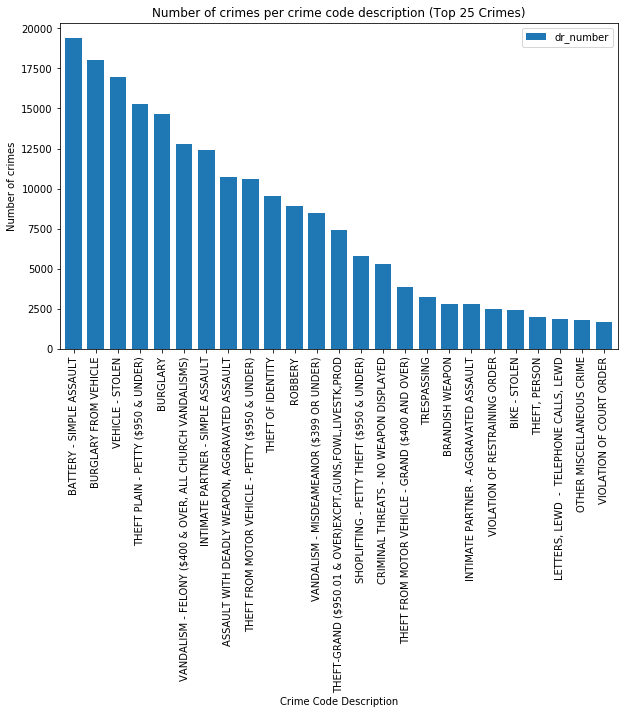

In [10]:
lapd_crime_data_2018_merged_case = lapd_crime_data_2018_merged.groupby('crime_code_description').count().sort_values(['dr_number'], ascending=False)
lapd_crime_data_2018_merged_case.head(25)
lapd_crime_data_2018_merged_case[:25].plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Crime Code Description')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per crime code description (Top 25 Crimes)')

Text(0.5,1,'Number of crimes per month')

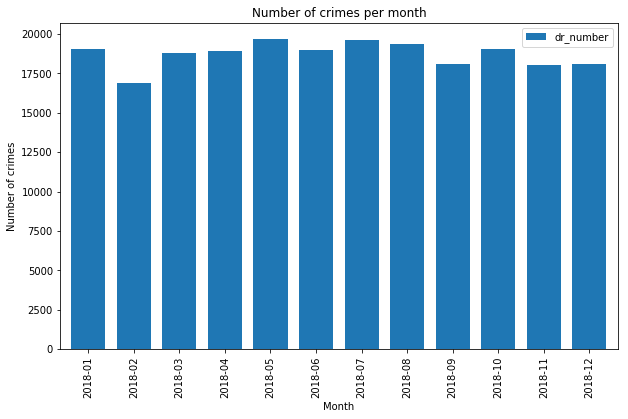

In [11]:
lapd_crime_data_2018_merged_month = lapd_crime_data_2018_merged.groupby('year_').count()
lapd_crime_data_2018_merged_month.head(25)
lapd_crime_data_2018_merged_month.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per month')

Text(0.5,1,'Number of crimes per day of week')

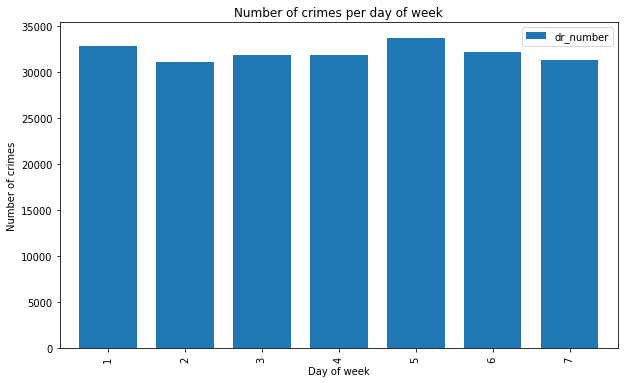

In [12]:
lapd_crime_data_2018_merged_day = lapd_crime_data_2018_merged.groupby('day').count()
lapd_crime_data_2018_merged_day.head(25)
lapd_crime_data_2018_merged_day.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Day of week')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per day of week')

Text(0.5,1,'Number of crimes per day of month')

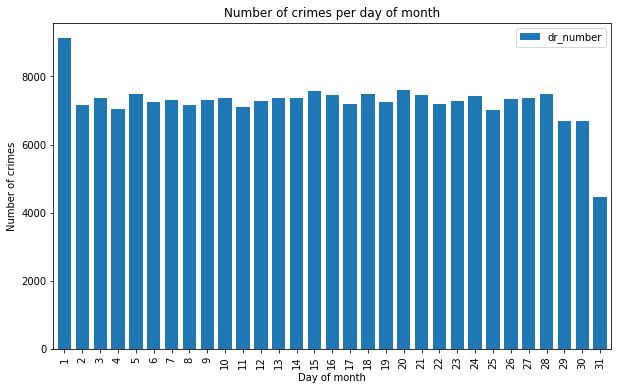

In [13]:
lapd_crime_data_2018_merged_date = lapd_crime_data_2018_merged.groupby('date').count()
lapd_crime_data_2018_merged_date.head(25)
lapd_crime_data_2018_merged_date.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Day of month')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per day of month')

Text(0.5,1,'Number of crimes per time of day')

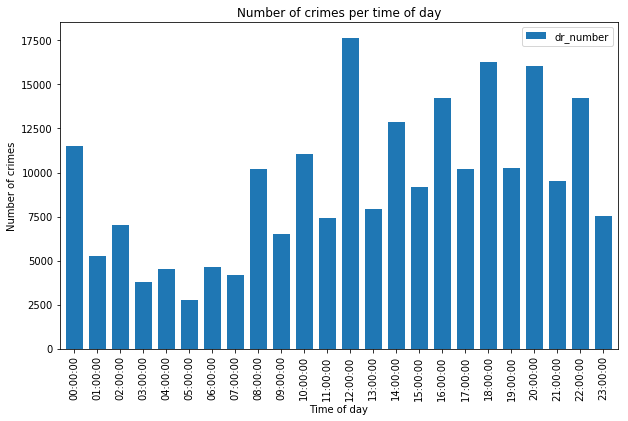

In [14]:
lapd_crime_data_2018_merged_time = lapd_crime_data_2018_merged.groupby('time_occurred').count()
lapd_crime_data_2018_merged_time.head(25)
lapd_crime_data_2018_merged_time.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Time of day')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per time of day')

Text(0.5,1,'Number of crimes per area')

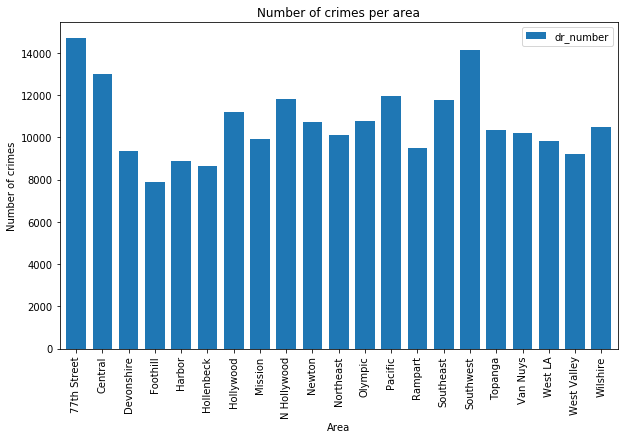

In [15]:
lapd_crime_data_2018_merged_area = lapd_crime_data_2018_merged.groupby('area_name').count()
lapd_crime_data_2018_merged_area.head(25)
lapd_crime_data_2018_merged_area.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Area')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per area')

In [16]:
address = 'Los Angeles, CA'
geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [17]:
lapd_crime_2018_top5 = lapd_crime_data_2018_merged_case.head(5).index.tolist()
lapd_crime_data_2018_top5 = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged['crime_code_description'].isin(lapd_crime_2018_top5)].reset_index(drop=True)

colors = ['red', 'blue', 'green', 'orange', 'purple'] 
colordict = dict(zip(lapd_crime_2018_top5, colors))
lapd_crime_data_2018_top5['color'] = lapd_crime_data_2018_top5['crime_code_description'].apply(lambda x: colordict[x])

In [18]:
# la_map = folium.Map(location=[latitude, longitude], zoom_start=11)
# la_map

# incidents = folium.map.FeatureGroup()
# for _, row in lapd_crime_data_2018_top5.iterrows():
#     popup_text = '{} <br> Date: {} <br> Time: {}'.format(row.crime_code_description, row.date_occurred, row.time_occurred)
    
#     incidents.add_child(
#         folium.features.CircleMarker(
#             [row.latitude_crime, row.longitude_crime],
#             radius = 2.5,
#             color = row.color,
#             popup = popup_text,
#             fill = True,
#             fill_color = col,
#             fill_opacity = 0.6,
#             prefer_canvas = True
#         )
#     )

# # add incidents to map
# la_map.add_child(incidents)
# la_map.save('la_map.html')

In [19]:
# la_cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# incidents = plugins.MarkerCluster().add_to(la_cluster_map)

# for lat, lng, label, in zip(lapd_crime_data_2018_top5.latitude_crime, lapd_crime_data_2018_top5.longitude_crime, lapd_crime_data_2018_top5.crime_code_description):
#     folium.Marker(
#         location = [lat, lng],
#         icon = None,
#         popup = label,
#     ).add_to(incidents)

# la_cluster_map.save('la_cluster_map.html')

In [20]:
# la_choropleth_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

# lapd_json = r'lapd-divisions.geojson'

# df_agg = lapd_crime_data_2018_merged.groupby(by='area_name').size().reset_index(name='count')

# threshold_scale = np.linspace(df_agg['count'].min(), df_agg['count'].max(), 6, dtype=int)
# threshold_scale = threshold_scale.tolist()
# threshold_scale[-1] += 1

# la_choropleth_map.choropleth(
#     legend_name = 'Crime Rate in Los Angeles',
#     threshold_scale=threshold_scale,
#     geo_data = lapd_json,
#     data = df_agg,
#     columns = ['area_name', 'count'],
#     key_on = 'feature.properties.name',
#     fill_color = 'YlOrRd',
#     fill_opacity = 0.7,
#     line_opacity = 0.2,
# )

# la_choropleth_map.save('la_choropleth_map.html')

In [21]:
# la_heat_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

# map_data = [[row.latitude_crime, row.longitude_crime] for _, row in lapd_crime_data_2018_merged.iterrows()]

# plugins.HeatMap(map_data,
#         min_opacity = 0.5,
#         max_zoom = 18, 
#         max_val = 1.0, 
#         radius = 12.5,
#         blur = 25,
#         gradient = None,
#         overlay = True).add_to(la_heat_map)

# la_heat_map.save('la_heat_map.html')

In [22]:
# def create_geojson_features(df):
#     features = []
#     for _, row in df.iterrows():
#         feature = {
#             'type': 'Feature',
#             'geometry': {
#                 'type':'Point', 
#                 'coordinates':[row['longitude_crime'],row['latitude_crime']]
#             },
#             'properties': {
#                 'time': row['dt'].date().__str__(),
#                 'style': {'color' : row['color']},
#                 'icon': 'circle',
#                 'iconstyle':{
#                     'fillColor': row['color'],
#                     'fillOpacity': 0.8,
#                     'stroke': 'true',
#                     'radius': 7
#                 }
#             }
#         }
#         features.append(feature)
#     return features

# def make_map(features):
#     coords = [latitude, longitude]
#     la_map_dynamic = folium.Map(location=coords, control_scale=True, zoom_start=8)

#     plugins.TimestampedGeoJson(
#         {'type': 'FeatureCollection',
#         'features': features}, 
#         period='P1M',
#         add_last_point=True,
#         auto_play=False,
#         loop=False
#     ).add_to(la_map_dynamic)
#     return la_map_dynamic

# features = create_geojson_features(lapd_crime_data_2018_top5)
# feature_collection = geojson.FeatureCollection(features)

# with open('myfile.geojson', 'w') as f:
#    geojson.dump(feature_collection, f)

# la_map_dynamic = make_map(features)
# la_map_dynamic.save('la_map_dynamic.html')

In [23]:
# heat_df = lapd_crime_data_2018_merged.copy()
# heat_df = heat_df[['latitude_crime', 'longitude_crime', 'month', 'date_occurred']]
# heat_df['Weight'] = heat_df['month']
# heat_df['Weight'] = heat_df['Weight'].astype(float)
# heat_df = heat_df.dropna(axis=0, subset=['latitude_crime','longitude_crime', 'Weight'])

# heat_data = [[[row['latitude_crime'],row['longitude_crime'],row['Weight']] 
#                 for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
#                  for i in range(1,13)]

# la_heat_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
# idx = lapd_crime_data_2018_merged.year_.unique().tolist()
# hm = plugins.HeatMapWithTime(heat_data, index=idx)
# hm.add_to(la_heat_map)

# # Display the map
# la_heat_map.save('la_heat_map_monthly_dynamic.html')

In [24]:
lapd_crime_data_2018_crime_by_date = lapd_crime_data_2018_merged['dt'].dt.date.value_counts().sort_index()

plot = figure(x_axis_type='datetime', tools='',
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Crime count', title='Hover over line to see crime counts', width=1800)

plot.line(lapd_crime_data_2018_crime_by_date.index, lapd_crime_data_2018_crime_by_date.values, 
          line_dash='4 4', line_width=1, color='red')

cr = plot.circle(lapd_crime_data_2018_crime_by_date.index, lapd_crime_data_2018_crime_by_date.values, size=10,
                fill_color='gold', hover_fill_color='black',
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color='black')
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)
# output_file('la_crime_by_date.html')
# save(plot)

In [25]:
dangerous_crimes = ['BATTERY - SIMPLE ASSAULT',
 'BURGLARY FROM VEHICLE',
 'VEHICLE - STOLEN',
 'THEFT PLAIN - PETTY ($950 & UNDER)',
 'BURGLARY',
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
 'BRANDISH WEAPON',
 'BATTERY WITH SEXUAL CONTACT',
 'RAPE, FORCIBLE',
 'OTHER ASSAULT',
 'DISCHARGE FIREARMS/SHOTS FIRED',
 'VEHICLE - ATTEMPT STOLEN',
 'CRIMINAL HOMICIDE',
 'BURGLARY FROM VEHICLE, ATTEMPTED',
 'PICKPOCKET',
 'KIDNAPPING',
 'THEFT FROM MOTOR VEHICLE - ATTEMPT',
 'PURSE SNATCHING',
 'RAPE, ATTEMPTED',
 'THEFT FROM PERSON - ATTEMPT',
 'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
 'PURSE SNATCHING - ATTEMPT',
 'PICKPOCKET, ATTEMPT']

In [26]:
features = lapd_crime_data_2018_merged[['crime_code_description', 'latitude_crime', 'longitude_crime']]
features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.hour, prefix='hour'))
features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.area_id, prefix='area'))
features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.day_))
features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.month_))
features['dangerous_crime'] = 0

features.loc[features.crime_code_description.isin(dangerous_crimes), 'dangerous_crime'] = 1

features.head()
# features.loc[features.violent_crime==1].head()

,crime_code_description,latitude_crime,longitude_crime,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,area_10,area_11,area_12,area_13,area_14,area_15,area_16,area_17,area_18,area_19,area_20,area_21,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September,dangerous_crime
0,VEHICLE - STOLEN,34.1329,-118.2084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,THEFT OF IDENTITY,34.2596,-118.4640,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,VEHICLE - STOLEN,34.0181,-118.4213,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,BATTERY - SIMPLE ASSAULT,34.0790,-118.3004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,BATTERY - SIMPLE ASSAULT,34.0790,-118.3004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [27]:
X = features.drop(['dangerous_crime', 'crime_code_description'], axis=1)
# X = preprocessing.StandardScaler().fit(X).transform(X)
y = features.dangerous_crime.values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [28]:
rf_model = RandomForestClassifier(n_estimators=200, max_features='auto').fit(X_train, y_train)

In [29]:
y_hat = rf_model.predict(X_test)

In [30]:
rf_model.score(X_test, y_test)

0.541636060100167

In [31]:
metrics.f1_score(y_test, y_hat, average='weighted')

0.5377072424246024

In [32]:
metrics.jaccard_similarity_score(y_test, y_hat)

0.541636060100167

In [33]:
importances = rf_model.feature_importances_

std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

sorted_important_features = []
for i in indices:
    sorted_important_features.append(X_test.columns[i])

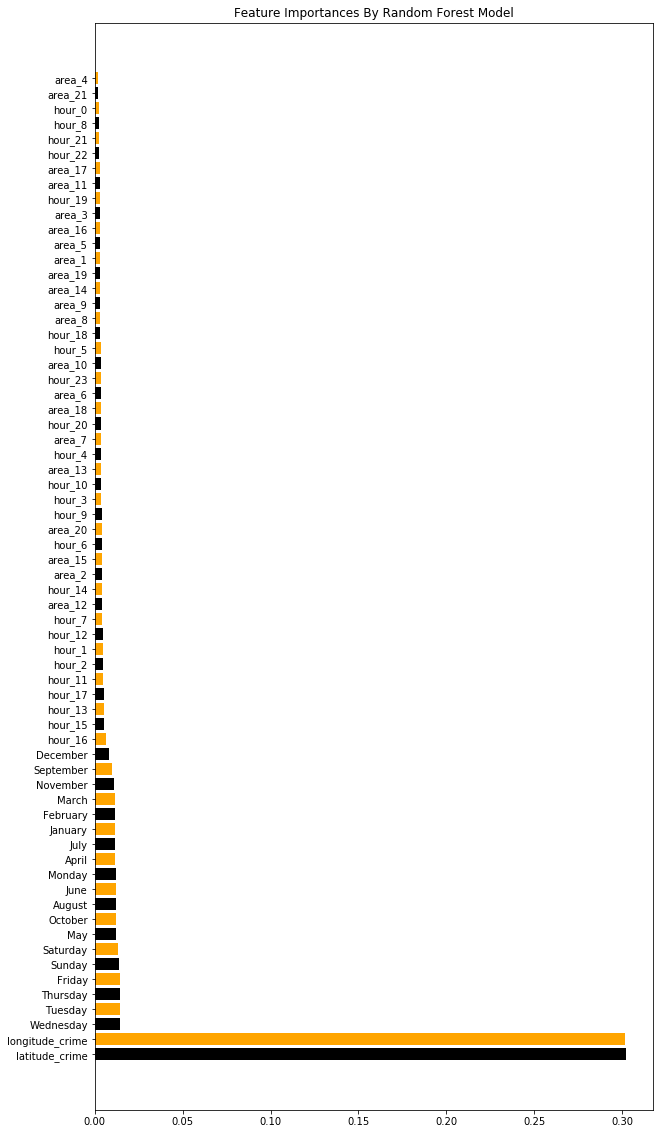

In [34]:
plt.figure(figsize=(10,20))
plt.title('Feature Importances By Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color=['black','orange'], yerr=std[indices], align='center')
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');